In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical 
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Read Text Captions
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [4]:
captions  = readTextFile("/content/drive/My Drive/PROJECTS/ML/Flickr_Data/Flickr_TextData/token.txt")
captions = captions.split('\n')[:-1]

In [5]:
print(len(captions))

4999


In [6]:
first,second  = captions[0].split('        ')
print(first.split(".")[0])
print(second)

﻿1
Military Man With severely injured Finger .


#Dictionary to Map each Image with the list of captions it has

In [7]:
descriptions = {}

for x in captions:
    first,second = x.split('        ')
    img_name = first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)

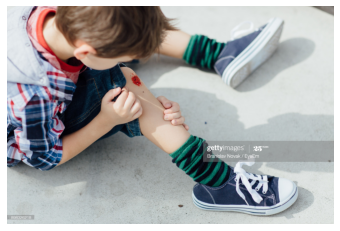

In [8]:
import pickle
IMG_PATH = "/content/drive/My Drive/PROJECTS/ML/Flickr_Data/Images/"
import cv2
img = cv2.imread(IMG_PATH+"121.jpg")
#print(img)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

Data Cleaning

In [9]:
#function to clean the sentences by removing any unwanted character
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [10]:
clean_text("A cat is sitting Over The house # 64")

'cat is sitting over the house'

In [11]:
# Cleaning all the Captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [12]:
# Write the data to text file
with open("descriptions_1000.txt","w") as f:
    f.write(str(descriptions))

Vocabulary

In [13]:
descriptions = None
with open("descriptions_1000.txt",'r',encoding='utf-8-sig') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [14]:
print(type(descriptions))

<class 'dict'>


In [15]:
# Now creating a Vocab
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 861


In [16]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))

Total Words 32612


In [17]:
# Filter Words from the Vocab according to certain threshold frequncy
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

861


In [18]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])
# Filter using threshold
threshold = 4
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [19]:
print(len(total_words))

859


In [20]:
train_file_data = readTextFile("/content/drive/My Drive/PROJECTS/ML/Flickr_Data/Flickr_TextData/train_images.txt")
test_file_data = readTextFile("/content/drive/My Drive/PROJECTS/ML/Flickr_Data/Flickr_TextData/test_images.txt")

In [21]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [22]:
train.pop(0)
train[:5]

['1', '2', '3', '4', '5']

In [23]:
# Prepare Description for the Training Data
# Adding <startseq> and <endseq> token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

#Transfer Learning
Images --> Features

Text ---> Features

#Step - 1 Image Feature Extraction


In [24]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

102973440/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [25]:
#removing the softmax layer
model_new = Model(model.input,model.layers[-2].output)

In [26]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

In [27]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [28]:
encode_image(IMG_PATH+"100.jpg")

array([0.32487223, 2.9247925 , 0.02457112, ..., 0.33181787, 0.16577344,
       0.01705527], dtype=float32)

In [29]:
encode_image(IMG_PATH+"101.jpg")

array([0.44336545, 0.64540744, 0.0827283 , ..., 0.07016777, 0.05337323,
       0.21678758], dtype=float32)

In [ ]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Total Time Taken : 500.1187860965729


In [ ]:
!mkdir saved1

In [ ]:
# Store everything to the disk 
with open("saved1/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [30]:
#opening saved file
with open('/content/drive/My Drive/PROJECTS/ML/Train and Test/1000_image/encoded_train_features.pkl', 'rb') as f:
    encoding_train = pickle.load(f)
print(type(encoding_train))

<class 'dict'>


In [31]:
test.pop(0)

''

In [32]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Total Time Taken(test) : 76.65141606330872


In [33]:
!mkdir saved1

In [34]:
with open("saved1/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [ ]:
#opening saved file


#Data pre-processing for Captions

In [35]:
# Vocab
len(total_words)

859

In [36]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [37]:
#word_to_idx["dog"]
#idx_to_word[1]
print(len(idx_to_word))

859


In [38]:
idx_to_word[860] = 'startseq'
word_to_idx['startseq'] = 860

idx_to_word[861] = 'endseq'
word_to_idx['endseq'] = 861

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 862


In [39]:
#finding the maximum length of the captions
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

28


Data Loader (Generator)

In [40]:
 
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield ([np.array(X1),np.array(X2)],np.array(y))
                    X1,X2,y = [],[],[]
                    n = 0

In [41]:
f = open("/content/drive/My Drive/PROJECTS/ML/GLOVE/glove.6B.50d.txt",encoding='utf8')

In [42]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [43]:
f.close()

In [44]:
embedding_index['injury']

array([ 0.19318  , -0.0072362, -0.54116  ,  0.070857 , -0.57301  ,
        1.1865   , -0.10865  ,  1.4757   ,  0.73861  , -0.059645 ,
        0.99569  ,  0.24435  , -2.0641   , -0.58036  ,  1.4317   ,
        0.26527  , -0.19271  , -1.3974   , -1.1261   ,  0.22634  ,
       -1.9279   ,  0.25428  , -0.47793  , -0.36595  ,  0.12171  ,
       -1.5167   ,  0.98992  ,  0.22429  ,  0.48438  ,  0.18187  ,
        2.7346   ,  0.79748  ,  0.99215  , -0.38546  ,  0.24519  ,
        1.4733   ,  1.4198   ,  0.5224   ,  1.0245   , -0.77324  ,
       -0.207    ,  0.44724  , -0.36914  ,  0.53611  ,  0.42736  ,
       -0.11228  ,  0.66118  ,  0.41869  ,  0.20125  , -0.25606  ])

In [45]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [46]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(862, 50)

#Model Architecture

In [47]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [48]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [49]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [50]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 28, 50)       43100       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
_______________________________________________________________________________________

In [51]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [52]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

Training of Model

In [53]:
epochs = 15
batch_size = 3
steps = len(train_descriptions)//batch_size

In [54]:
 for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
    model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save('/content/drive/My Drive/PROJECTS/ML/Flickr_Data/Model_weights_1000_images/model_'+str(i)+'.h5')

333/333 [==============================] - 4s 11ms/step - loss: 1.1375


In [55]:
#model = load_model('./model_weights/model_9.h5')
import tensorflow as tf
new_model = tf.keras.models.load_model('/content/drive/My Drive/PROJECTS/ML/Flickr_Data/Model_weights_1000_images/model_14.h5')

In [56]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

Identification of dangerous situations

In [57]:
fname = '/content/drive/My Drive/PROJECTS/ML/Flickr_Data/List of Dangerous words.txt'
word_positions = {}
with open(fname, 'r') as textfile:
    words = (word for line in textfile.readlines() for word in line.split())
    word_positions = {i: word for i, word in enumerate(words)}

In [58]:
word_positions.pop(0)

'\ufeffchoking'

In [59]:
word_positions[0]='choking'

In [60]:
res = dict((v,k) for k,v in word_positions.items())
print(len(res))

157


In [61]:
str="blood is lying all over floor"
if any(x in str for x in res):
    print ("Found a match")
else:
    print ("Not a match")

Found a match


#METEOR SCORE CALCULATION

In [62]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [72]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
from itertools import chain, product


def _generate_enums(hypothesis, reference):
    hypothesis_list = list(enumerate(hypothesis.lower().split()))
    reference_list = list(enumerate(reference.lower().split()))
    return hypothesis_list, reference_list

def exact_match(hypothesis, reference):
    hypothesis_list, reference_list = _generate_enums(hypothesis, reference)
    return _match_enums(hypothesis_list, reference_list)



def _match_enums(enum_hypothesis_list, enum_reference_list):
    word_match = []
    for i in range(len(enum_hypothesis_list))[::-1]:
        for j in range(len(enum_reference_list))[::-1]:
            if enum_hypothesis_list[i][1] == enum_reference_list[j][1]:
                word_match.append(
                    (enum_hypothesis_list[i][0], enum_reference_list[j][0])
                )
                (enum_hypothesis_list.pop(i)[1], enum_reference_list.pop(j)[1])
                break
    return word_match, enum_hypothesis_list, enum_reference_list


def _enum_stem_match(
    enum_hypothesis_list, enum_reference_list, stemmer=PorterStemmer()
):
    stemmed_enum_list1 = [
        (word_pair[0], stemmer.stem(word_pair[1])) for word_pair in enum_hypothesis_list
    ]

    stemmed_enum_list2 = [
        (word_pair[0], stemmer.stem(word_pair[1])) for word_pair in enum_reference_list
    ]

    word_match, enum_unmat_hypo_list, enum_unmat_ref_list = _match_enums(
        stemmed_enum_list1, stemmed_enum_list2
    )

    enum_unmat_hypo_list = (
        list(zip(*enum_unmat_hypo_list)) if len(enum_unmat_hypo_list) > 0 else []
    )

    enum_unmat_ref_list = (
        list(zip(*enum_unmat_ref_list)) if len(enum_unmat_ref_list) > 0 else []
    )

    enum_hypothesis_list = list(
        filter(lambda x: x[0] not in enum_unmat_hypo_list, enum_hypothesis_list)
    )

    enum_reference_list = list(
        filter(lambda x: x[0] not in enum_unmat_ref_list, enum_reference_list)
    )

    return word_match, enum_hypothesis_list, enum_reference_list


def stem_match(hypothesis, reference, stemmer=PorterStemmer()):

    enum_hypothesis_list, enum_reference_list = _generate_enums(hypothesis, reference)
    return _enum_stem_match(enum_hypothesis_list, enum_reference_list, stemmer=stemmer)



def _enum_wordnetsyn_match(enum_hypothesis_list, enum_reference_list, wordnet=wordnet):
    word_match = []
    for i in range(len(enum_hypothesis_list))[::-1]:
        hypothesis_syns = set(
            chain(
                *[
                    [
                        lemma.name()
                        for lemma in synset.lemmas()
                        if lemma.name().find("_") < 0
                    ]
                    for synset in wordnet.synsets(enum_hypothesis_list[i][1])
                ]
            )
        ).union({enum_hypothesis_list[i][1]})
        for j in range(len(enum_reference_list))[::-1]:
            if enum_reference_list[j][1] in hypothesis_syns:
                word_match.append(
                    (enum_hypothesis_list[i][0], enum_reference_list[j][0])
                )
                enum_hypothesis_list.pop(i), enum_reference_list.pop(j)
                break
    return word_match, enum_hypothesis_list, enum_reference_list


def wordnetsyn_match(hypothesis, reference, wordnet=wordnet):
    enum_hypothesis_list, enum_reference_list = _generate_enums(hypothesis, reference)
    return _enum_wordnetsyn_match(
        enum_hypothesis_list, enum_reference_list, wordnet=wordnet
    )



def _enum_allign_words(
    enum_hypothesis_list, enum_reference_list, stemmer=PorterStemmer(), wordnet=wordnet
):
    exact_matches, enum_hypothesis_list, enum_reference_list = _match_enums(
        enum_hypothesis_list, enum_reference_list
    )

    stem_matches, enum_hypothesis_list, enum_reference_list = _enum_stem_match(
        enum_hypothesis_list, enum_reference_list, stemmer=stemmer
    )

    wns_matches, enum_hypothesis_list, enum_reference_list = _enum_wordnetsyn_match(
        enum_hypothesis_list, enum_reference_list, wordnet=wordnet
    )

    return (
        sorted(
            exact_matches + stem_matches + wns_matches, key=lambda wordpair: wordpair[0]
        ),
        enum_hypothesis_list,
        enum_reference_list,
    )


def allign_words(hypothesis, reference, stemmer=PorterStemmer(), wordnet=wordnet):
    enum_hypothesis_list, enum_reference_list = _generate_enums(hypothesis, reference)
    return _enum_allign_words(
        enum_hypothesis_list, enum_reference_list, stemmer=stemmer, wordnet=wordnet
    )



def _count_chunks(matches):
    i = 0
    chunks = 1
    while i < len(matches) - 1:
        if (matches[i + 1][0] == matches[i][0] + 1) and (
            matches[i + 1][1] == matches[i][1] + 1
        ):
            i += 1
            continue
        i += 1
        chunks += 1
    return chunks


def single_meteor_score(
    reference,
    hypothesis,
    preprocess=str.lower,
    stemmer=PorterStemmer(),
    wordnet=wordnet,
    alpha=0.9,
    beta=3,
    gamma=0.5,
):
    enum_hypothesis, enum_reference = _generate_enums(
        hypothesis, reference
    )
    translation_length = len(enum_hypothesis)
    reference_length = len(enum_reference)
    matches, _, _ = _enum_allign_words(enum_hypothesis, enum_reference, stemmer=stemmer)
    matches_count = len(matches)
    try:
        precision = float(matches_count) / translation_length
        recall = float(matches_count) / reference_length
        fmean = (precision * recall) / (alpha * precision + (1 - alpha) * recall)
        chunk_count = float(_count_chunks(matches))
        frag_frac = chunk_count / matches_count
    except ZeroDivisionError:
        return 0.0
    penalty = gamma * frag_frac ** beta
    return (1 - penalty) * fmean



def meteor_score(
    references,
    hypothesis,
    stemmer=PorterStemmer(),
    wordnet=wordnet,
    alpha=0.9,
    beta=3,
    gamma=0.5,
):
    return max(
        [
            single_meteor_score(
                reference,
                hypothesis,
                stemmer=stemmer,
                wordnet=wordnet,
                alpha=alpha,
                beta=beta,
                gamma=gamma,
            )
            for reference in references
        ]
    )

In [73]:
round(meteor_score(
    ["this is an apple", "that is an apple"], "an apple on this tree"),4)

0.6233

In [74]:
round(meteor_score(["this is an apple", "that is an apple"], "an apple on this tree"),4)

0.6233

#Printing Images with their generated captions and their BLEU and METEOR score

Dangerous Image
METEOR SCORE:  0.9977


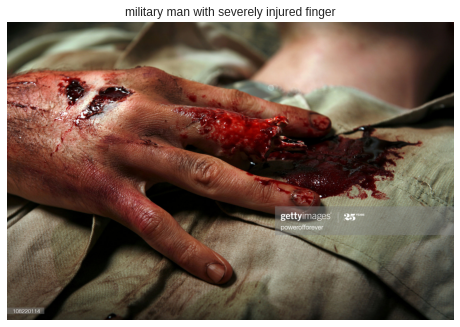

Dangerous Image
METEOR SCORE:  0.9977


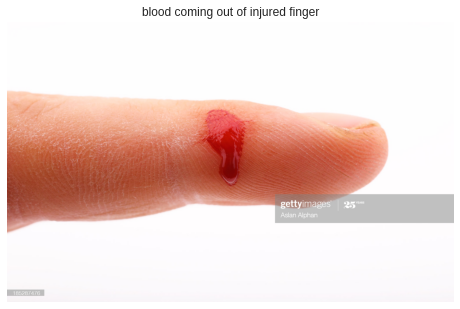

Dangerous Image
METEOR SCORE:  0.0862


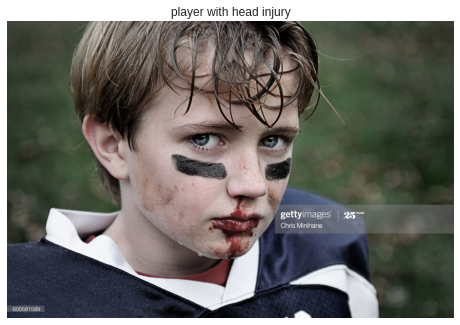

Dangerous Image
METEOR SCORE:  0.996


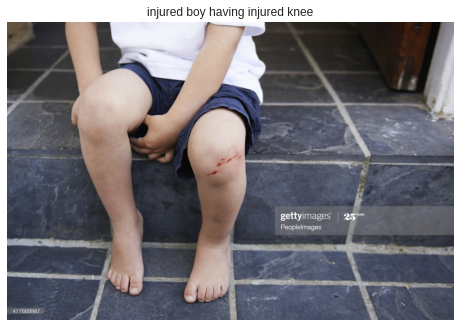

Dangerous Image
METEOR SCORE:  0.0


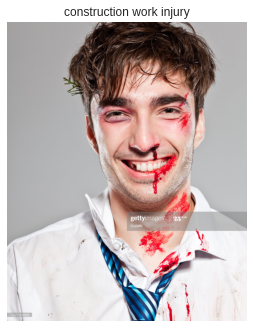

Dangerous Image
METEOR SCORE:  0.3775


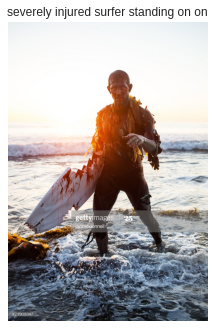

Dangerous Image
METEOR SCORE:  0.0


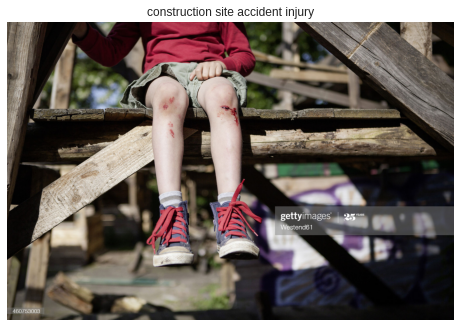

Dangerous Image
METEOR SCORE:  0.755


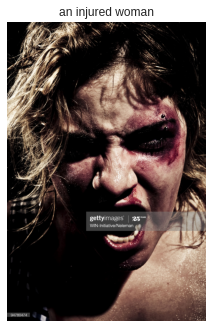

Dangerous Image
METEOR SCORE:  0.0


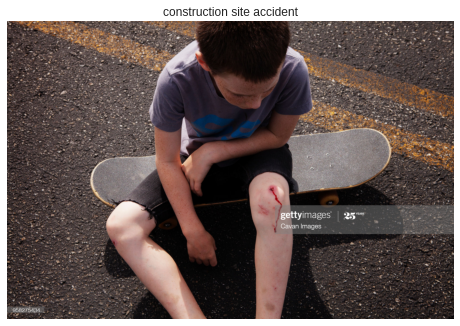

Not Dangerous Image
METEOR SCORE:  0.0


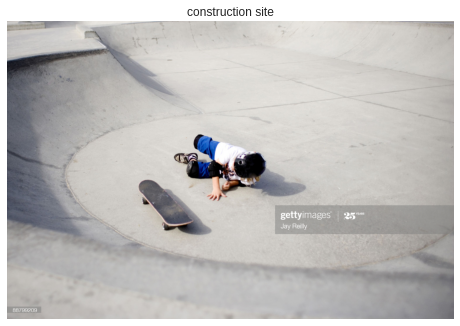

Dangerous Image
METEOR SCORE:  0.0


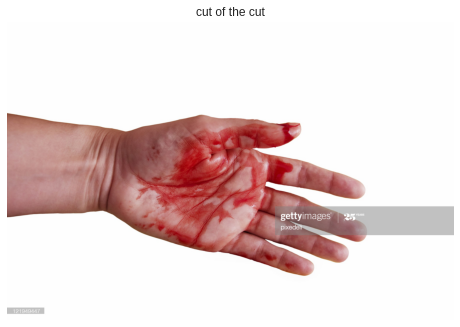

Dangerous Image
METEOR SCORE:  0.7653


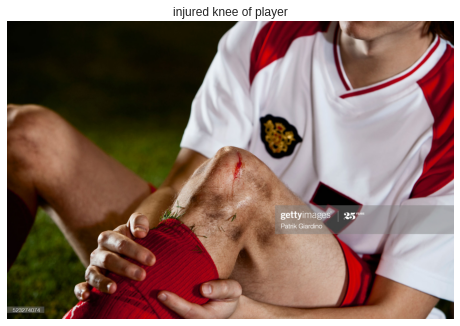

Dangerous Image
METEOR SCORE:  0.4573


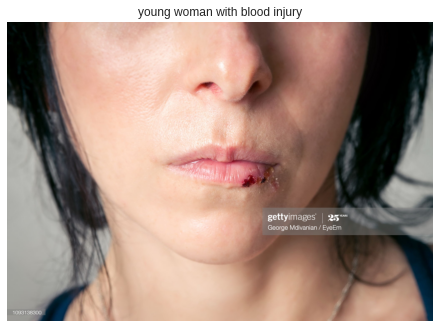

Dangerous Image
METEOR SCORE:  0.9977


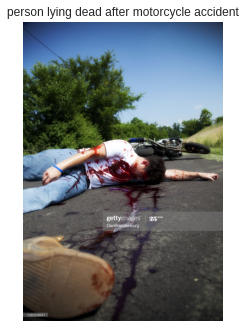

Dangerous Image
METEOR SCORE:  0.8413


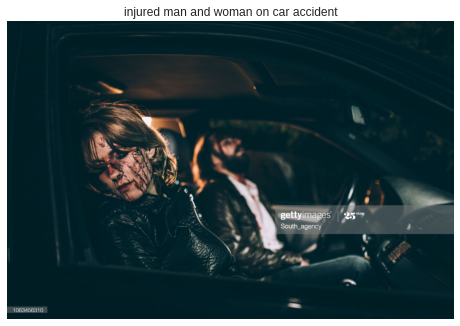

In [91]:
# Pick Some Random Images and See Results
cum_meteor=0
plt.style.use("seaborn")
for i in range(15):
    idx = i
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("/content/drive/My Drive/PROJECTS/ML/Flickr_Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    if any(x in caption for x in res):
      print ("Dangerous Image")
    else:
      print ("Not Dangerous Image")
    print("METEOR SCORE: ",(round(meteor_score(descriptions[img_name], caption),4)))
    cum_meteor=cum_meteor+round(meteor_score(descriptions[img_name], caption),4)
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

In [92]:
print("METEOR Score : ",(cum_meteor/15))

METEOR Score :  0.48478
